In [31]:
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.datasets import DatasetFolder
from PIL import Image
from torch.utils.data import ConcatDataset,DataLoader,Subset,Dataset
import gc

#数据增强
train_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(180),
    transforms.RandomGrayscale(),
    transforms.ToTensor(),
    
])

test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

batch_size = 128

def load_pic(x):
    return Image.open(x)

train_set_1 = DatasetFolder("/kaggle/input/dataset/food-11/training/labeled", lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
train_set_2 = DatasetFolder("/kaggle/input/dataset/food-11/training/labeled", lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
valid_set = DatasetFolder("/kaggle/input/dataset/food-11/validation", lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
unlabeled_set = DatasetFolder("/kaggle/input/dataset/food-11/training/unlabeled", lambda x: Image.open(x), extensions="jpg", transform=train_tfm)

test_set = DatasetFolder("/kaggle/input/dataset/food-11/testing", lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
train_set = ConcatDataset([train_set_1, train_set_2]) 
print(len(train_set))


# data_loader
train_loader = DataLoader(train_set, batch_size=batch_size,  num_workers=2, pin_memory=True,shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size,  num_workers=2, pin_memory=True,shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

6160


epoch 1  train_acc: 0.19204545454545455 ,val_acc: 0.1984848484848485
epoch 2  train_acc: 0.29594155844155845 ,val_acc: 0.3303030303030303
epoch 3  train_acc: 0.32175324675324674 ,val_acc: 0.36515151515151517
epoch 4  train_acc: 0.3646103896103896 ,val_acc: 0.39090909090909093
epoch 5  train_acc: 0.38701298701298703 ,val_acc: 0.36363636363636365
epoch 6  train_acc: 0.41363636363636364 ,val_acc: 0.43787878787878787
epoch 7  train_acc: 0.4366883116883117 ,val_acc: 0.43787878787878787
epoch 8  train_acc: 0.45081168831168833 ,val_acc: 0.4636363636363636
epoch 9  train_acc: 0.474025974025974 ,val_acc: 0.4257575757575758
epoch 10  train_acc: 0.49464285714285716 ,val_acc: 0.45
epoch 11  train_acc: 0.522077922077922 ,val_acc: 0.4696969696969697
epoch 12  train_acc: 0.5342532467532467 ,val_acc: 0.4818181818181818
epoch 13  train_acc: 0.5405844155844156 ,val_acc: 0.47424242424242424
epoch 14  train_acc: 0.5477272727272727 ,val_acc: 0.5
epoch 15  train_acc: 0.5732142857142857 ,val_acc: 0.518181818

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:186: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:187: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.


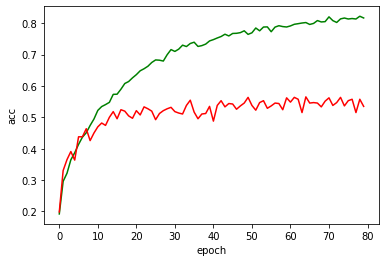

In [34]:
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn as nn


class Mydataset(Dataset):
    def __init__(self, x ,y):
        self.data=x
        self.label=y
    def __getitem__(self,idx):
        return self.data[idx],self.label[idx]
    def __len__(self):
        return len(self.data)
    
#半监督学习打伪标签
def pseudo_label(model,unlabel_set):
    model.eval()
    print("start labeling")
    c=0
    data_loader=DataLoader(unlabel_set,batch_size=1,shuffle=False)
    dataset_1=Mydataset(x=torch.tensor([]),y=torch.tensor([]))
    dataset_2=Mydataset(x=torch.tensor([]),y=torch.tensor([]))
    dataset_3=Mydataset(x=torch.tensor([]),y=torch.tensor([]))
    for j,data in enumerate(data_loader):
        inputs,_=data
        inputs=inputs.to("cuda")
        outputs=model(inputs)
        softmax=nn.Softmax(dim=-1)
        s=softmax(outputs)
        per,labels=torch.max(s,dim=1)
        if(j<=2000):
            if(per.sum().item()>0.65 and c==0):
                dataset_1=Mydataset(x=inputs,y=labels)
                c=c+1
            elif (per.sum().item()>0.65):
                dataset=Mydataset(x=inputs,y=labels)
                dataset_1=ConcatDataset([dataset_1,dataset])
                c=c+1
        if(2000<j<=4000):
            
            if (per.sum().item()>0.65):
                dataset=Mydataset(x=inputs,y=labels)
                dataset_2=ConcatDataset([dataset_2,dataset])
                c=c+1
        if(4000<j<=6000):
            if (per.sum().item()>0.65):
                dataset=Mydataset(x=inputs,y=labels)
                dataset_3=ConcatDataset([dataset_3,dataset])
                c=c+1
    print("number of new labeled samples: ",c)
    dataset_1=ConcatDataset([dataset_1,dataset_2])
    dataset_1=ConcatDataset([dataset_1,dataset_3])
    print("start semi-supervised learning")  
    return dataset_1


#网络结构
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.cn=nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(4, 4, 0),
            
        )
        self.fc=nn.Sequential(
            nn.Linear(256 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(256, 11)
        )
    def forward(self,x):
        x=self.cn(x)
        x = x.flatten(1)
        x=self.fc(x)
        return x


LEARNING_RATE=0.0001
EPOCH=80

model=Net().to("cuda")
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=LEARNING_RATE,weight_decay=1e-5)


train_acc_list=[]
val_acc_list=[]
i=0
semi=False
for i in range(EPOCH):
    train_acc=0.0
    train_loss=0.0
    val_acc=0.0
    val_loss=0.0
        
    #网络训练
    model.train()
    for j,data in enumerate(train_loader):
        inputs,labels=data
       
        inputs=inputs.to("cuda")
        labels=labels.to("cuda")
        outputs=model(inputs)
        loss=criterion(outputs,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss+=loss
        _,pred=torch.max(outputs,dim=1)
        train_acc+=(pred.cpu()==labels.cpu()).sum().item()
    gc.collect()
    torch.cuda.empty_cache()
    
    #半监督学习
    if semi:
        for _,data in enumerate(unlabeled_loader):
            optimizer.zero_grad()
            inputs,labels=data
            inputs=inputs.to("cuda")
            labels=labels.to("cuda")
            outputs=model(inputs)
            loss=criterion(outputs,labels)
            loss.backward()
            optimizer.step()
    gc.collect()
    torch.cuda.empty_cache()

    #验证集验证
    model.eval()
    with torch.no_grad():
        for j,data in enumerate(valid_loader):
            inputs,labels=data
            inputs=inputs.to("cuda")
            labels=labels.to("cuda")
            outputs=model(inputs)
            loss=criterion(outputs,labels)
            val_loss+=loss
            _,pred=torch.max(outputs,dim=1)
            val_acc+=(pred.cpu()==labels.cpu()).sum().item()
    
    #计算准确度和损失值    
    train_acc=train_acc/len(train_set)
    val_acc=val_acc/len(valid_set)
    train_loss=train_loss/len(train_loader)
    val_loss=val_loss/len(valid_loader)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    print("epoch",i+1," train_acc:",train_acc,",val_acc:",val_acc)
    
    #打伪标签
    if(val_acc>0.55 and semi==False ):
        unlabeled_sett=pseudo_label(model,unlabeled_set)
        unlabeled_loader=DataLoader(unlabeled_sett, batch_size=batch_size, num_workers=0, shuffle=False)
        semi=True

plt.figure()
x=range(0,80)
plt.xlabel("epoch")
plt.ylabel("acc")
plt.plot(x,train_acc_list, 'r-',color='g',label='train_acc')
plt.plot(x,val_acc_list,'r-',color='r',label='val_acc')
plt.show()